In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchvision, torch

In [3]:
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil
import json
import glob

In [4]:
dmerge = datasets.get_data("nih")

NIH_Dataset num_samples=67310 views=['PA'] data_aug=None


In [5]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [6]:
model = xrv.models.DenseNet(weights="all").cuda()

In [7]:
print(model.pathologies)
print(model)

['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
XRV-DenseNet121-all


In [8]:
for_eval = [
            "Cardiomegaly",
            "Atelectasis",
            "Effusion",
            "Consolidation",
            "Edema",
            "Mass"
            ]

In [9]:
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
temp_path = "/lscratch/joecohen/SDS-2342-ASDAA"

In [10]:
target = "Effusion"
label = 1

In [11]:
print(target)
sample = dmerge[3089]
csv = dmerge.csv.iloc[[3089]]
image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

Effusion


[0.5404265] -20 2


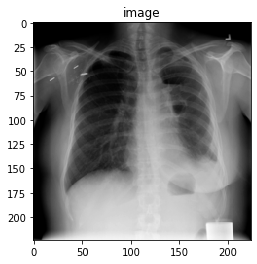

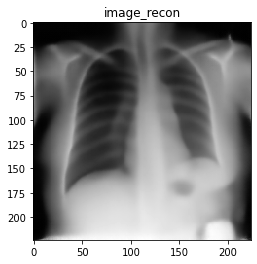

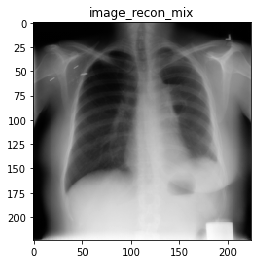

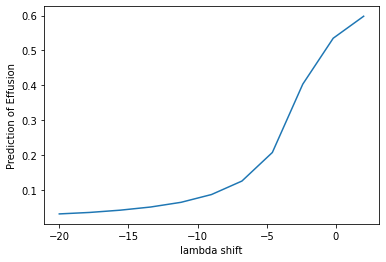

In [12]:
temp_path = "/lscratch/joecohen/SDS-2342-ASDAA"
a = attribution.compute_attribution(image.cuda(), "latentshift-max", model, target, plot=True, ae=ae);


[0.5404265] -20 2
0
10
20
module load ffmpeg;ffmpeg -loglevel quiet -stats -y -i /lscratch/joecohen/SDS-2342-ASDAA/image-%d-a.png -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'


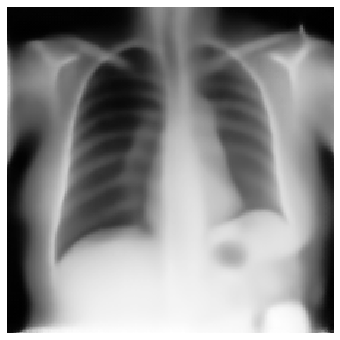

In [13]:
attribution.generate_video(image.cuda(), model, target, ae, temp_path, target_filename="test", border=False, show=True)

In [14]:
params = attribution.compute_attribution(image.cuda(), "latentshift", model, target, ret_params=True, ae=ae)


[0.5404265] -20 2


In [30]:
params.keys()

dict_keys(['dimgs', 'lambdas', 'y', 'initial_pred'])

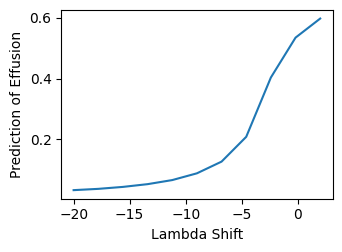

In [15]:
fig, ax = plt.subplots(1,1, figsize=(3.5,2.5), dpi=100)
plt.plot(params["lambdas"],params["y"])
plt.xlabel("Lambda Shift");
plt.ylabel("Prediction of " + target);
plt.show()

In [16]:
dimgs = np.concatenate(params["dimgs"],1)[0]

In [17]:
np.concatenate(dimgs,1).shape

(224, 2464)

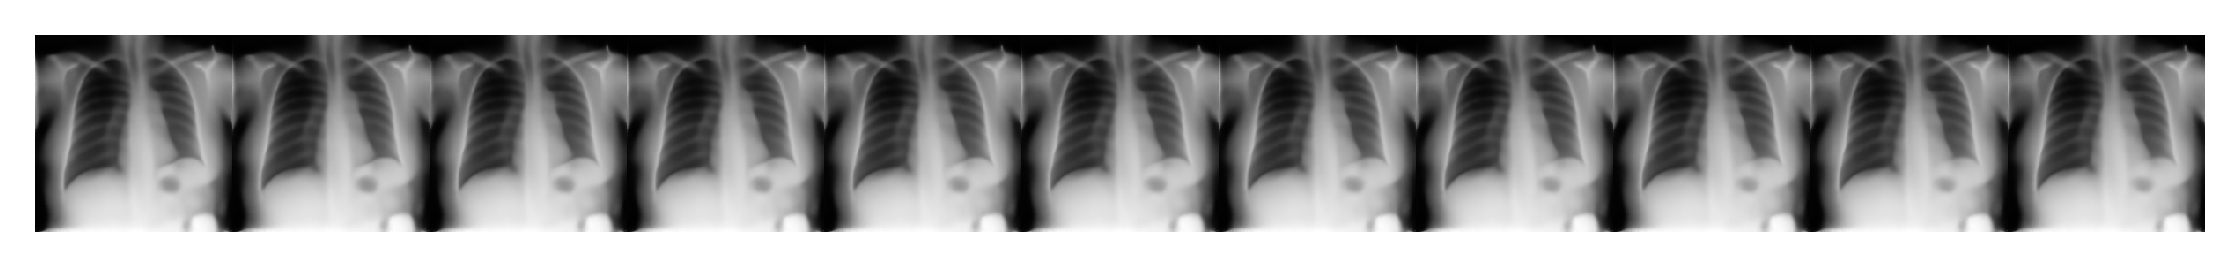

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=350)
plt.imshow(np.concatenate(dimgs,1), interpolation='none', cmap="gray");
plt.axis('off');

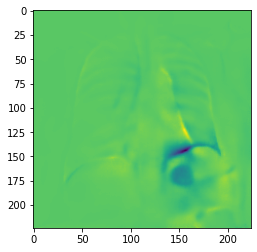

In [19]:
plt.imshow(dimgs[0] -  dimgs[-1]);

In [20]:
import opticalflow

In [45]:
uu = []
vv = []
for i in range(len(dimgs)-1):
    v, u = opticalflow.optical_flow_ilk(dimgs[i], dimgs[i+1])
    uu.append(u)
    vv.append(v)
u = np.asarray(uu).mean(0)
v = np.asarray(vv).mean(0)

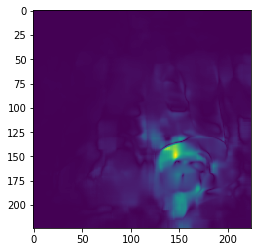

In [46]:
norm = np.sqrt(u ** 2 + v ** 2)
plt.imshow(norm, interpolation='none')

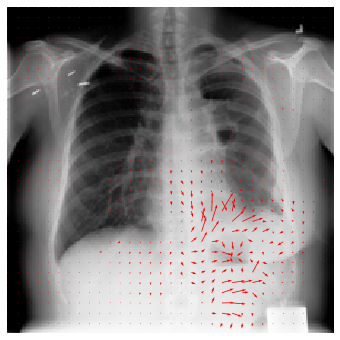

In [53]:
nvec =30  # Number of vectors to be displayed along each image dimension
nl, nc = dimgs[0].shape
step = max(nl//nvec, nc//nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

ar = u_ * v_
u_ = u_ * (ar > np.percentile(ar, 0))
v_ = v_ * (ar > np.percentile(ar, 0))


fig = plt.Figure(figsize=(6, 6), dpi=50)
gcf = plt.gcf()
gcf.set_size_inches(6,6)
plt.imshow(image.cpu().numpy()[0][0], interpolation='none', cmap='Greys_r');
plt.quiver(x, y, u_, v_, color='r', units='dots',
           angles='xy', scale_units='xy', lw=3, scale=0.05);
plt.axis('off');